In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import mesaPlot as mp
import pandas as pd
import pprint
import csv
import pickle
import multiprocessing
from mint_general_interpolation_grid_builder.functions_natalie.custom_mpl_settings import (
    load_mpl_rc,
)
load_mpl_rc()
cmap = plt.get_cmap('viridis')
m = mp.MESA()


from mint_general_interpolation_grid_builder.MINT.src.MINT_table_builders.MS_table_builder import MainSequenceTableBuilder
from mint_general_interpolation_grid_builder.MINT.src.MINT_table_builders.GB_table_builder import RedGiantBranchTableBuilder
from mint_general_interpolation_grid_builder.MINT.src.MINT_table_builders.CHeB_table_builder import (
    CoreHeliumBurningTableBuilder,
)
from mint_general_interpolation_grid_builder.MINT.src.MINT_table_builders.EAGB_table_builder import (
    EarlyAsymptoticGiantBranchTableBuilder,
)
from mint_general_interpolation_grid_builder.MINT.config.table_columns import table_columns


evol_phase = 'CHeB'

settings = {
    **table_columns,
    'grid_directory':f'/Users/natalierees/MINT_grids_23051/Z0.02/{evol_phase}',
    'metallicity':0.02,
    'num_processes':4
}

if evol_phase == 'MS':
    tester = MainSequenceTableBuilder(settings=settings)
elif evol_phase == 'GB':
    tester = RedGiantBranchTableBuilder(settings=settings)
elif evol_phase == 'CHeB':
    tester = CoreHeliumBurningTableBuilder(settings=settings)
elif evol_phase == 'EAGB':
    tester = EarlyAsymptoticGiantBranchTableBuilder(settings=settings)



Building a grid with (X_0, Y_0, Z_0)=(0.7, 0.28, 0.02)


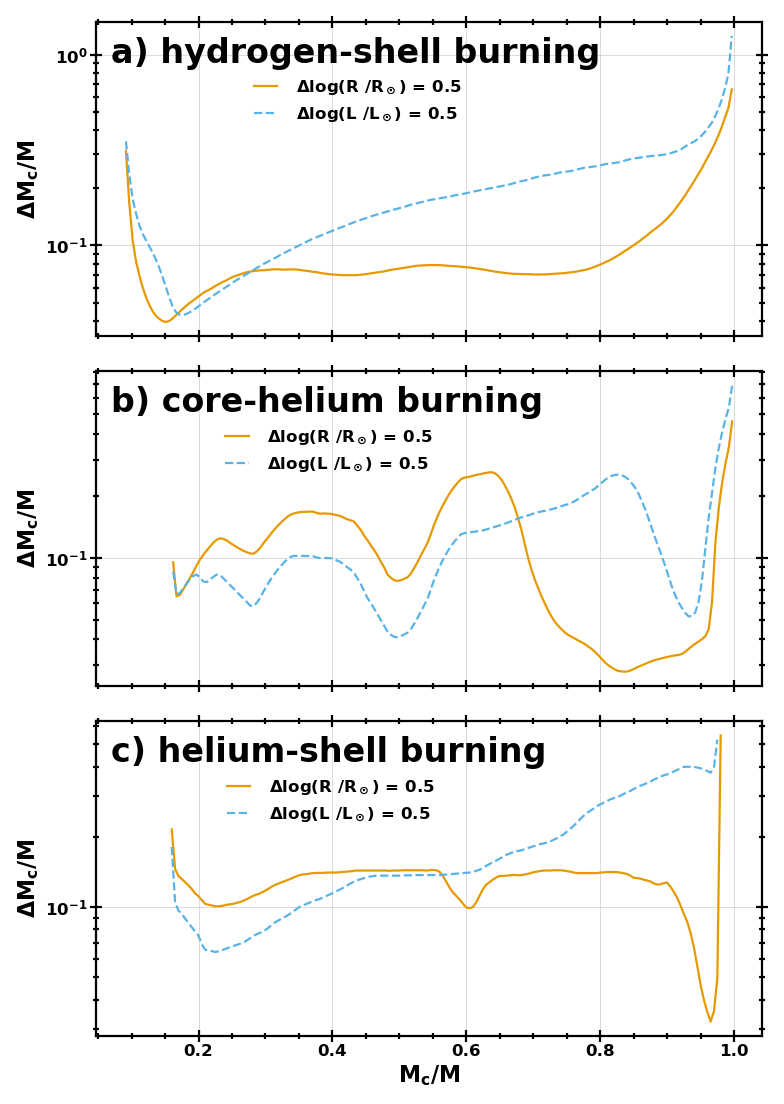

In [4]:
def calc_deta(x,q_name='LOG_RADIUS',delta_target = 0.05):
    if len(x) > 1:
        return delta_target/np.abs(np.gradient(x[q_name],x['HELIUM_CORE_MASS_FRACTION']))
    
def calc_core_mass_resolution(
        df,
        tp_name = 'CENTRAL_DEGENERACY',
        q_name = 'LOG_RADIUS',
        delta_target = 0.05,
        quantile = 0.1
        ):
    allowed_deta = df.groupby(['MASS',tp_name]).apply(lambda x: calc_deta(x,q_name,delta_target))
    allowed_deta = pd.DataFrame(allowed_deta,columns=['Values'])['Values'].apply(pd.Series).quantile(quantile)
    allowed_deta.index = df['HELIUM_CORE_MASS_FRACTION'].unique()
    return allowed_deta.rolling(window=10).mean().dropna().sort_index()

delta_target_common = 0.5
delta_target_dict = {'LOG_RADIUS':delta_target_common,'LOG_LUMINOSITY':delta_target_common}
label_dict = {'LOG_RADIUS':r'$\Delta \log (R~/\mathrm{R}_\odot)$ = ',
              'LOG_LUMINOSITY':r'$\Delta \log (L~/\mathrm{L}_\odot)$ = ',}

fig,ax=plt.subplots(3,1,figsize=(10,14),sharex=True)

for i, evol_phase in enumerate(['GB','CHeB','EAGB']):

    tp_name = tester.settings[f'{evol_phase}_scalar_input_columns'][1]
    df = tester.load_table(evol_phase=evol_phase)
    df = df[['MASS',tp_name,'HELIUM_CORE_MASS_FRACTION','LOG_RADIUS','LOG_LUMINOSITY']]
    df_remapped = tester.remap_data_to_orthogonal_grid(df,tp_name,"HELIUM_CORE_MASS_FRACTION")
    df_mass = df_remapped[df_remapped['MASS']>0.9]

    for quantity, delta_target in delta_target_dict.items():
        allowed_deta = calc_core_mass_resolution(
            df_mass,
            # df_remapped,
            tp_name = tp_name,
            q_name = quantity,
            delta_target = delta_target,
            quantile = 0.05
            )

        ax[i].plot(np.array(allowed_deta.index),(allowed_deta.values),label=label_dict[quantity]+str(delta_target_dict[quantity]))
        
        ax[i].set(ylabel=r'$\Delta M_\mathrm{c}/M$')
        # ax[i].set_ylim(-1.75,0)
        ax[i].set_yscale('log')

ax[2].set(xlabel='$M_\mathrm{c}/M$')
ax[0].legend(title='a) hydrogen-shell burning')
ax[1].legend(title='b) core-helium burning')
ax[2].legend(title='c) helium-shell burning')

fig.tight_layout()
plt.savefig(f'plots/core_mass_resolution.jpeg',dpi=200)
